# Salinity budget over top 50 m of convective region

Significant parts of this code is from a notebook written by Lucan Laurindo (used in Laurindo et al. 2024, GRL), which has some code based on the [pop-tools heat budget notebook](https://pop-tools.readthedocs.io/en/latest/examples/CloseHeatBudget_POP2.html) written by Anna-Lena Deppenmeier.

For the sake of time, I just computed the CONV region average of each component of the advection term separately in this notebook, saved them, then used the processed data in a separate notebook to make Figure 3.

In [1]:
# Configure dask;
# =====================================================================================>
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client, progress

import dask
with dask.config.set({"distributed.scheduler.worker-saturation": 1.0}):
    client = Client(n_workers=10, 
                    threads_per_worker=5, 
                    memory_limit='165GB')
client
# =====================================================================================>

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rford2/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rford2/proxy/8787/status,Workers: 10
Total threads: 50,Total memory: 1.50 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39555,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rford2/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43839,Total threads: 5
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rford2/proxy/42925/status,Memory: 153.67 GiB
Nanny: tcp://127.0.0.1:42733,


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pop_tools

In [3]:
spy = 60*60*24*365

In [4]:
def conv_box(da, vert=False):
    da_region = da.where((da.TLAT >= -69) & (da.TLAT <= -64) & ((da.TLONG >= 354) | (da.TLONG <= 19)), drop=True)
    if vert == True:
        return da_region.isel(z_t=slice(0, 5)).load()
    else: return da_region.load()

def annual(da):
    return da.resample(time='1YE').mean().isel(time=slice(1, -1))

In [5]:
crmask = xr.open_dataset('../data/HRCESM-CRMASK2.nc')

In [6]:
crb = conv_box(crmask.conv_region, vert=False)

In [7]:
crb_tend_salt = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-TEND_SALT-full.nc')

In [8]:
crb_sfwf = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-SFWF-full.nc')

In [9]:
crb_qflux = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-QFLUX-full.nc')

In [10]:
crb_ues = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-UES-full.nc')

In [11]:
crb_vns = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-VNS-full.nc')

In [12]:
crb_wts = xr.open_dataset('/glade/derecho/scratch/rford2/ihesp-gn/HRCESM-CRB-WTS-full.nc')

In [13]:
ds0 = xr.open_dataset('/glade/campaign/collections/rda/data/d651029/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/tseries/month_1/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.SFWF.033001-033912.nc')

In [14]:
# =====================================================================================>
# Thickness of the T Cells;
dz = ds0.dz.values

# K-index of Deepest Grid Cell on T Grid and on U Grid;
KMT = ds0.KMT.values.astype(int)
KMU = ds0.KMU.values.astype(int)

# Ocean depth at T points and at U points;
HT = ds0.HT.values
HU = ds0.HU.values

# Area of T cells and of U cells;
TAREA = ds0.TAREA.values
UAREA = ds0.UAREA.values

# Save the length of relevant dimensions;
NZ = len(dz)
NY = KMT.shape[0]
NX = KMT.shape[1]

# 3-D matrix with the z-spacing of the grid cells in T Grid;
# ------------------------------------------------------------------------------------->
DZBC = np.full((NY,NX),np.nan)
for ii in range(0,NY):
    for jj in range(0,NX):
        if (KMT[ii,jj] > 0):
            DZBC[ii,jj] = HT[ii,jj] - np.sum(dz[0:KMT[ii,jj]-1])
            
DZVA_3D = np.ones((NZ,NY,NX))
for ii in range(0,NZ):
    DZVA_3D[ii,:,:] = DZVA_3D[ii,:,:]*dz[ii]
    
DZT = DZVA_3D
for ii in range(0,NY):
    for jj in range(0,NX):
        if (KMT[ii,jj] > 0):
            DZT[int(KMT[ii,jj]-1),ii,jj] = DZBC[ii,jj]
            
# Define a DataArray;
DZT = xr.DataArray(DZT,
                   dims = ['z_t','nlat','nlon'],
                   name = 'DZT',
                   coords = {'z_t': ds0.z_t,
                             'ULAT': ds0.ULAT,
                             'ULONG': ds0.ULONG,
                             'TLAT': ds0.TLAT,
                             'TLONG': ds0.TLONG},
                   attrs = {"long_name": "Thickness of U cells",
                            "units": "centimeter",
                            "grid_loc": "3111"}) 
# ------------------------------------------------------------------------------------->

# 3-D matrix with the z-spacing of the grid cells in U Grid;
# ------------------------------------------------------------------------------------->
DZBC = np.full((NY,NX),np.nan)
for ii in range(0,NY):
    for jj in range(0,NX):
        if (KMU[ii,jj] > 0):
            DZBC[ii,jj] = HU[ii,jj] - np.sum(dz[0:KMU[ii,jj]-1])
            
DZVA_3D = np.ones((NZ,NY,NX))
for ii in range(0,NZ):
    DZVA_3D[ii,:,:] = DZVA_3D[ii,:,:]*dz[ii]
    
DZU = DZVA_3D
for ii in range(0,NY):
    for jj in range(0,NX):
        if (KMU[ii,jj] > 0):
            DZU[int(KMU[ii,jj]-1),ii,jj] = DZBC[ii,jj]
            
# Define a DataArray;
DZU = xr.DataArray(DZU,
                   dims = ['z_t','nlat','nlon'],
                   name = 'DZU',
                   coords = {'z_t': ds0.z_t,
                             'ULAT': ds0.ULAT,
                             'ULONG': ds0.ULONG,
                             'TLAT': ds0.TLAT,
                             'TLONG': ds0.TLONG},
                   attrs = {'long_name': 'Thickness of U cells',
                            'units': 'centimeter',
                            'grid_loc': '3221'}) 
# ------------------------------------------------------------------------------------->
# =====================================================================================>

In [15]:
# Merges all DataArrays of interest in a single Dataset;
# =====================================================================================>
# Defines empty dataset;
ds = xr.Dataset()

# Fills the dataset with datarrays holding the grid information;
# ------------------------------------------------------------------------------------->
ds['time'] = crb_ues.time
ds['z_w_bot'] = ds0.z_w_bot
ds['z_w_top'] = ds0.z_w_top
ds['z_t_150m'] = ds0.z_t_150m
ds['z_w'] = ds0.z_w
ds['z_t'] = ds0.z_t
ds['dz'] = ds0.dz
# ds['ULAT'] = ds0.ULAT
# ds['ULONG'] = ds0.ULONG
# ds['TLAT'] = ds0.TLAT
# ds['TLONG'] = ds0.TLONG

ds['TAREA'] = conv_box(ds0.TAREA)
ds['KMT'] = conv_box(ds0.KMT)
ds['DXT'] = conv_box(ds0.DXT)
ds['DYT'] = conv_box(ds0.DYT)

ds['UAREA'] = conv_box(ds0.UAREA)
ds['KMU'] = conv_box(ds0.KMU)
ds['DXU'] = conv_box(ds0.DXU)
ds['DYU'] = conv_box(ds0.DYU)
# ------------------------------------------------------------------------------------->

# Fills the dataset with datarrays holding the geophysical quantities;
# ------------------------------------------------------------------------------------->
#ds['SALT'] = ds0.SALT
#ds['TEND_SALT'] = ds1.TEND_SALT
ds['UES'] = crb_ues.UES
ds['VNS'] = crb_vns.VNS
ds['WTS'] = crb_wts.WTS
ds['conv_region'] = crb
#ds['SFWF'] = ds5.SFWF
# ------------------------------------------------------------------------------------->

# Set coordinates;
ds = ds.set_coords(['z_t','z_t_150m','z_w','z_w_top','z_w_bot','time','TLONG','TLAT','ULONG','ULAT'])

# Adds extra dataarrays with the grid information;
ds['DZT'] = conv_box(DZT)
ds['DZU'] = conv_box(DZU)

# Converts the stored datarrays to single-precision;
ds = ds.astype("float32")
# =====================================================================================>

In [16]:
# Preprocesses data;
# =====================================================================================>
# Obtain volume of T Cells (Anna's code); 
# ------------------------------------------------------------------------------------->
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds.KMT.compute()

for jj in range(len(KMT.nlat)):
    for ii in range(len(KMT.nlon)):
        kk = KMT.values[jj, ii].astype(int)
        VOL.values[kk:, jj, ii] = 0.0

ds['VOL'] = VOL
ds.VOL.attrs['long_name'] = 'volume of T cells'
ds.VOL.attrs['units'] = 'centimeter^3'
ds.VOL.attrs['grid_loc'] = '3111'
# ------------------------------------------------------------------------------------->

# Processes the time axis;
# ------------------------------------------------------------------------------------->
# Decode the time coordinates into datetime format;
ds = xr.decode_cf(ds)

# Isolates the time axes;
tt_grid = ds.indexes['time']

# Saves the length of the time axis;
NT = len(tt_grid)

# Defines time vector with arbitrary time stamps;
ts_grid = np.arange(0,NT)
# ------------------------------------------------------------------------------------->

# ------------------------------------------------------------------------------------->
metrics = {("X",): ["DXU", "DXT"],  # X distances
           ("Y",): ["DYU", "DYT"],  # Y distances
           ("Z",): ["DZU", "DZT"],  # Z distances
           ("X", "Y"): ["UAREA", "TAREA"],}

gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},)

In [17]:
dsxgcm

<xarray.Dataset> Size: 71GB
Dimensions:      (z_t: 62, nlat_t: 118, nlon_t: 250, nlat_u: 118, nlon_u: 250,
                  time: 3240, z_w_top: 62, nlat: 118, nlon: 250, z_w_bot: 62,
                  z_t_150m: 15)
Coordinates: (12/13)
  * time         (time) object 26kB 0250-02-01 00:00:00 ... 0520-01-01 00:00:00
  * z_w_bot      (z_w_bot) float32 248B 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_t_150m     (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top      (z_w_top) float32 248B 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_t          (z_t) float32 248B 500.0 1.5e+03 ... 5.625e+05 5.875e+05
    ULONG        (nlat_u, nlon_u) float64 236kB -5.9 -5.8 -5.7 ... 18.9 19.0
    ...           ...
    TLONG        (nlat_t, nlon_t) float64 236kB 354.1 354.2 ... 18.85 18.95
    TLAT         (nlat_t, nlon_t) float64 236kB -68.96 -68.96 ... -64.0 -64.0
  * nlon_u       (nlon_u) int64 2kB 1 2 3 4 5 6 7 ... 245 246 247 248 249 250
  * nlat_u       (nlat_u) int64 944B 1 2 3 4 5 6 7 ... 113 114 115 116 117 118
  * nlon_t       (nlon_t) float64 2kB 0.5 1.5 2.5 3.5 ... 247.5 248.5 249.5
  * nlat_t       (nlat_t) float64 944B 0.5 1.5 2.5 3.5 ... 115.5 116.5 117.5
Dimensions without coordinates: nlat, nlon
Data variables: (12/16)
    dz           (z_t) float32 248B 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    TAREA        (nlat_t, nlon_t) float32 118kB 1.875e+11 ... 2.377e+11
    KMT          (nlat_t, nlon_t) float32 118kB 49.0 48.0 48.0 ... 59.0 59.0
    DXT          (nlat_t, nlon_t) float32 118kB 3.991e+05 ... 4.874e+05
    DYT          (nlat_t, nlon_t) float32 118kB 4.699e+05 ... 4.877e+05
    UAREA        (nlat_u, nlon_u) float32 118kB 1.877e+11 ... 2.381e+11
    ...           ...
    VNS          (time, z_t, nlat_u, nlon_t) float32 24GB 3.39e-16 ... nan
    WTS          (time, z_w_top, nlat_t, nlon_t) float32 24GB nan nan ... nan
    conv_region  (nlat, nlon) float32 118kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DZT          (z_t, nlat_t, nlon_t) float32 7MB 1e+03 1e+03 ... 2.5e+04
    DZU          (z_t, nlat_u, nlon_u) float32 7MB 1e+03 1e+03 ... 2.5e+04
    VOL          (z_t, nlat_t, nlon_t) float32 7MB 1.875e+14 1.875e+14 ... 0.0

In [18]:
tend_salt_m = crb_tend_salt.TEND_SALT.isel(z_t=slice(0, 5)).where(crb).weighted(ds.TAREA).mean(dim=['nlon', 'nlat'])

In [19]:
lhf = ds0.latent_heat_fusion.values
sfc_flux_50m = -0.0347*(crb_sfwf.SFWF - crb_qflux.QFLUX/(1e4*lhf))/50

In [20]:
sfc_flux_50m_m = sfc_flux_50m.where(crb).weighted(ds.TAREA).mean(dim=['nlon', 'nlat'])

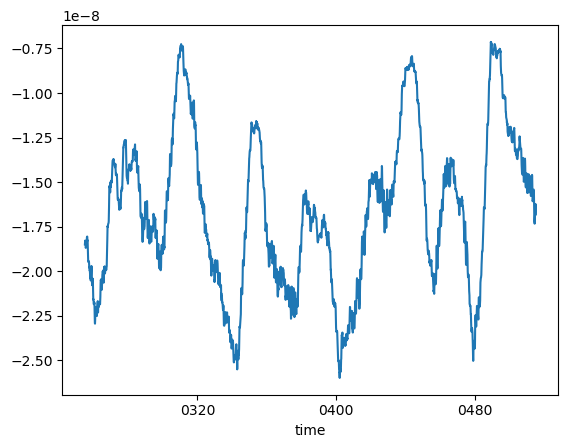

In [21]:
sfc_flux_50m_m.rolling(time=120, center=True).mean().plot()

In [22]:
zonal_adv = -(gridxgcm.diff(dsxgcm.UES * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
# merid_adv = -(gridxgcm.diff(dsxgcm.VNS * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
# vert_adv = (gridxgcm.diff(dsxgcm.WTS.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z") / dsxgcm.VOL)
# total_adv = zonal_adv + merid_adv + vert_adv

In [23]:
u_adv_ts = (zonal_adv.isel(z_t=slice(0, 5)).where(dsxgcm.conv_region.rename({'nlat': 'nlat_t', 'nlon': 'nlon_t'})).weighted(dsxgcm.TAREA).mean(dim=['nlon_t', 'nlat_t', 'z_t']))
# v_adv_ts = (merid_adv.isel(z_t=slice(0, 5)).where(dsxgcm.conv_region.rename({'nlat': 'nlat_t', 'nlon': 'nlon_t'})).weighted(dsxgcm.TAREA).mean(dim=['nlon_t', 'nlat_t', 'z_t']))
# w_adv_ts = (vert_adv.isel(z_t=slice(0, 5)).where(dsxgcm.conv_region.rename({'nlat': 'nlat_t', 'nlon': 'nlon_t'})).weighted(dsxgcm.TAREA).mean(dim=['nlon_t', 'nlat_t', 'z_t']))

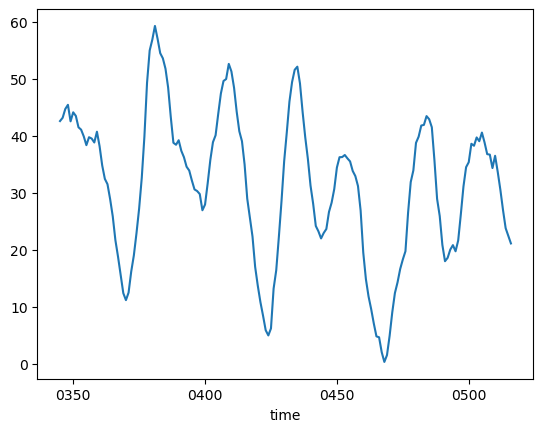

In [24]:
annual(spy*u_adv_ts.sel(time=slice('0338-02', None))).rolling(time=10, center=True).mean().plot()
# annual(spy*v_adv_ts.sel(time=slice('0338-02', None))).rolling(time=10, center=True).mean().plot()
# annual(spy*w_adv_ts.sel(time=slice('0338-02', None))).rolling(time=10, center=True).mean().plot()

In [25]:
# u_adv_ts.to_dataset(name='u_adv').to_netcdf('../data/u_adv_ts2.nc')
# v_adv_ts.to_dataset(name='v_adv').to_netcdf('../data/v_adv_ts2.nc')
# w_adv_ts.to_dataset(name='w_adv').to_netcdf('../data/w_adv_ts2.nc')